<a href="https://colab.research.google.com/github/JairsonAlbertoSami/desafio-junior-data-scientis/blob/main/visualizacao_Analise_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instala BigQuery e basedosdados

!pip install google-cloud-bigquery
!pip install basedosdados

In [82]:
import basedosdados as bd
import pandas as pd
import plotly.express as px
from shapely import wkt

In [2]:
project_id = "datariojairson"

In [3]:
from google.colab import auth
auth.authenticate_user()

# **Localização de chamados do 1746**

Utilize a tabela de Chamados do 1746 e a tabela de Bairros do Rio de Janeiro para as perguntas de 1-5.




# 1. **Quantos chamados foram abertos no dia 01/04/2023?**

In [22]:
data_especifica = '2023-04-01'

consulta_sql = f"""
SELECT *
FROM `datario.adm_central_atendimento_1746.chamado`
WHERE DATE(data_inicio) = '{data_especifica}'
"""

df_chamados = bd.read_sql(consulta_sql, billing_project_id=project_id)

Downloading: 100%|██████████| 1756/1756 [00:01<00:00, 1666.55rows/s]


In [24]:
df_chamados.head(2)

,id_chamado,id_origem_ocorrencia,data_inicio,data_fim,id_bairro,id_territorialidade,id_logradouro,numero_logradouro,id_unidade_organizacional,nome_unidade_organizacional,...,data_real_diagnostico,tempo_prazo,prazo_unidade,prazo_tipo,dentro_prazo,situacao,tipo_situacao,justificativa_status,reclamacoes,data_particao
0,18516878,11,2023-04-01 10:49:16,2023-04-03 22:37:36,5,1,62026,119,8,RIOLUZ - Companhia Municipal de Energia e Ilum...,...,NaT,<NA>,D,F,No prazo,Encerrado,Atendido,None,0,2023-04-01
1,18518304,11,2023-04-01 20:54:06,2023-04-03 23:37:38,5,1,62323,95,8,RIOLUZ - Companhia Municipal de Energia e Ilum...,...,NaT,<NA>,D,F,No prazo,Encerrado,Atendido,None,0,2023-04-01


In [71]:
df_chamado_0104 = df_chamados[df_chamados['data_inicio'].dt.date == pd.to_datetime('2023-04-01').date()]
contagem_chamados_hora = df_chamado_0104['data_inicio'].dt.hour.value_counts().sort_index()

In [72]:
df_plotly = pd.DataFrame({
    'Hora': contagem_chamados_hora.index,
    'Número de Chamados': contagem_chamados_hora.values
})

fig = px.bar(df_plotly, x='Hora', y='Número de Chamados',
             title='Chamados abertos em 01/04/2023 por hora')

fig.update_layout(
    title_x=0.5,
    width=1300,
    height=600,
    xaxis_tickangle=-45
)

print(f"Foram abertos {len(df_chamado_0104)} chamados no dia 2023-04-01.")

fig.show()

Foram abertos 1756 chamados no dia 2023-04-01.


# 2. **Qual o tipo de chamado que teve mais teve chamados abertos no dia 01/04/2023?**

In [79]:
df_chamado_0104.tipo.value_counts().index[0]

'Estacionamento irregular'

In [80]:
fig = px.bar(df_chamado_0104['tipo'].value_counts()[:10],
             x=df_chamado_0104['tipo'].value_counts()[:10].index,
             y=df_chamado_0104['tipo'].value_counts()[:10].values,
             labels={'x': 'Tipo de Chamado', 'y': 'Número de Chamados'},
             title='Top 10 Tipos de Chamados Mais Frequentes em 01/04/2023')

fig.update_layout(
    title_x=0.5,
    width=1000,
    height=600,
    xaxis_tickangle=-45
)

fig.show()

# **3. Quais os nomes dos 3 bairros que mais tiveram chamados abertos nesse dia?**

In [111]:
# from shapely import wkt
df_dados_mestres = bd.read_sql("SELECT* FROM `datario.dados_mestres.bairro`",
                 billing_project_id = project_id)

df_dados_mestres['geometry'] = df_dados_mestres['geometry'].apply(wkt.loads)

Downloading: 100%|██████████| 164/164 [00:03<00:00, 49.71rows/s]


In [112]:
df_dados_mestres.dtypes

,0
id_bairro,object
nome,object
id_area_planejamento,object
id_regiao_planejamento,object
nome_regiao_planejamento,object
id_regiao_administrativa,object
nome_regiao_administrativa,object
subprefeitura,object
area,float64
perimetro,float64


In [113]:
df_mestre_chamados_merged = pd.merge(df_dados_mestres, df_chamados, on='id_bairro', how='outer')

top_3_bairros_merged = df_mestre_chamados_merged['nome'].value_counts().nlargest(3)

In [114]:
import geopandas as gpd

bairro_chamados = gpd.GeoDataFrame(df_mestre_chamados_merged, geometry='geometry', crs='epsg:4326')

In [115]:
bairro_chamados['Mapa RJ'] = 'juntar'

In [116]:
rj_map =bairro_chamados.dissolve(by='Mapa RJ')

<Axes: >

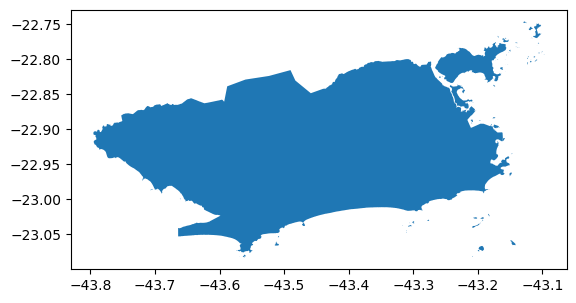

In [127]:
rj_map.plot()